# Face Detection Analysis

On this notebook the important elements to analyse are:
* **Detection time relative to frame rate and area:** The frame size and the total duration of the video impact on the time spent detecting. We can change the resolution but not the length of the video, instead we can change the frequency the detection happens.
* **Face area relative to frame scale and frame size threshold:** Changing the resolution of the video can impact on the number of faces we detect.
* **Content delta distribution to select threshold:** For the next stage of the pipeline a threshold is required for shot transitions.

In [1]:
import json
from pathlib import Path
from itertools import chain
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
def read_data(detection_path, data_fn):
    files = list(Path(detection_path).glob(r'**/*.detections.json'))
    loop = tqdm(files)
    for file in loop:
        with file.open('r', encoding='utf8') as fp:
            try:
                obj = json.load(fp)
            except json.JSONDecodeError as err:
                loop.write('ERROR:', file)
                continue
            for row in data_fn(file, obj):
                yield row

## Detection time relative to frame rate and area

In [3]:
def get_data(file, obj):
    yield {
        'video_id': file.name[:file.name.index('.')],
        'frame_rate': obj['frame_rate'],
        'area': obj['width'] * obj['height'],
        'speedup': obj['video_length'] / obj['detection_length'],
        'batch_size': obj['batch_size'],
    }

path = r'\\Desktop-0331tte\d\chiletv-testdata\detection'
df1 = pd.DataFrame(read_data(path, get_data))
df1.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [05:56<00:00,  1.68it/s]


,video_id,frame_rate,area,speedup,batch_size
0,-75gXEApdNQ,15.0,2073600,0.207788,34
1,0VrxAn-goEw,15.0,409920,0.432342,192
2,0yTEcgQNoQo,15.0,169200,1.325616,512
3,1dCoXH61eyc,15.0,921600,0.555311,96
4,26wTw6UGoAY,15.0,921600,0.440480,110


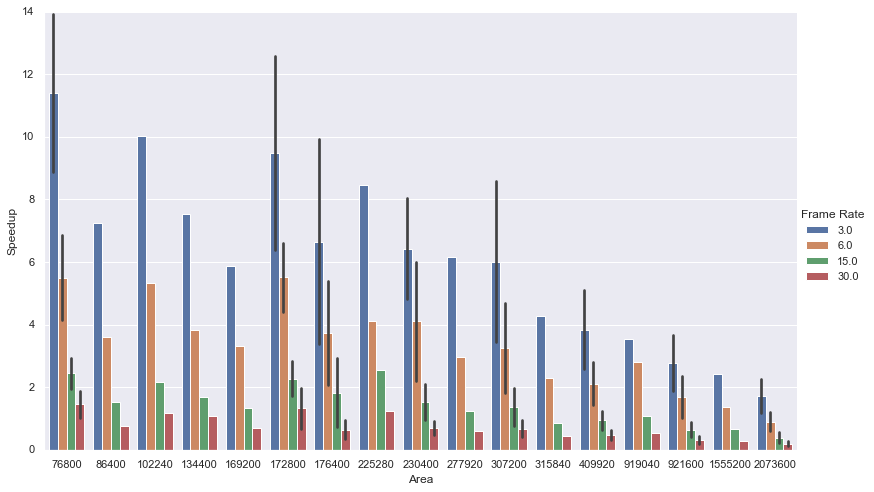

In [4]:
g = sns.catplot(data=df1, kind='bar', x='area', y='speedup', hue='frame_rate', ci='sd', height=7, aspect=1.618)
g._legend.set_title('Frame Rate')
g.set(xlabel='Area', ylabel='Speedup')

plt.savefig('images/speedup_by_frame_rate.svg', bbox_inches='tight')
plt.savefig('images/speedup_by_frame_rate.png', bbox_inches='tight')

**Figure \[speedup_by_frame_rate]:** A decrease in the frame rate does improve the time spent detecting faces. The bin which would contain the videos with a resolution of 550x550 is highlithed.

[None]

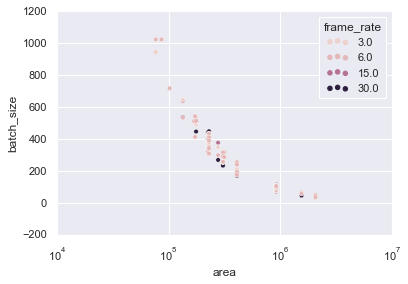

In [5]:
g = sns.scatterplot(data=df1, x='area', y='batch_size', hue='frame_rate')
g.set(xscale='log')

## Face area relative to frame scale and frame size threshold

In [6]:
def get_data(file, obj):
    row = {
        'video_id': file.name[:file.name.index('.')],
        'folder': file.parent.name,
        'frame_scale': obj.get('frame_scale', float(file.parent.name[1:file.parent.name.index('-')])),
    }
    for bbox_list in obj['bounding_box']:
        for bbox in bbox_list:
            # row['bbox_area'] = ((bbox[2] - bbox[0]) / obj['width']) * ((bbox[3] - bbox[1]) / obj['height'])
            row['bbox_width'] = bbox[2] - bbox[0]
            row['bbox_height'] = bbox[3] - bbox[1]
            yield row.copy()

path = r'\\Desktop-0331tte\d\chiletv-testdata\det-scale'
df2 = pd.DataFrame(read_data(path, get_data))
df2.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████| 402/402 [01:02<00:00,  6.46it/s]


,video_id,folder,frame_scale,bbox_width,bbox_height
0,-75gXEApdNQ,S.125-none@3FPS,0.125,319.573975,409.630630
1,-75gXEApdNQ,S.125-none@3FPS,0.125,286.788086,389.508743
2,-75gXEApdNQ,S.125-none@3FPS,0.125,296.237427,403.799393
3,-75gXEApdNQ,S.125-none@3FPS,0.125,290.576233,388.960663
4,-75gXEApdNQ,S.125-none@3FPS,0.125,287.846680,397.267441


In [7]:
df2['bbox_area'] = df2['bbox_width'] * df2['bbox_height']


[Text(0.5, 0, 'Frame scale'), Text(0, 0.5, 'Number of faces')]

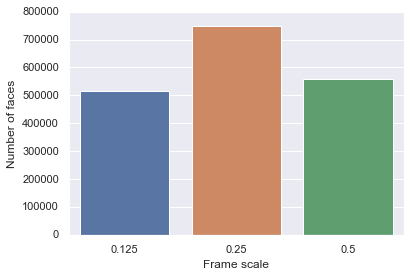

In [8]:
g = sns.barplot(x='frame_scale', y='bbox_area', data=df2, estimator=len)
g.set(xlabel='Frame scale', ylabel='Number of faces')

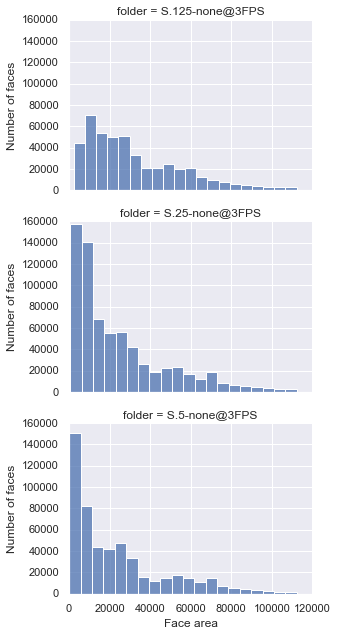

In [9]:
mean = df2['bbox_area'].mean()
std = df2['bbox_area'].std()
g = sns.FacetGrid(df2[df2['bbox_area'] < mean+std], row='folder', aspect=1.618, sharex=True, sharey=True)
g.map_dataframe(sns.histplot, x='bbox_area', bins=20)
g.set(xlabel='Face area', ylabel='Number of faces')

## Content delta distribution to select threshold

In [10]:
def get_data(file, obj):
    video_id = file.name[:file.name.index('.')]
    fps = int(obj['frame_rate'])
    
    t_array = np.float32(obj['time'])
    c_array = np.float32(obj['content_delta'])
    t_array = t_array / t_array.max()
    
    for t, c in zip(t_array, c_array):
        yield {'video_id':video_id, 'frame_rate':fps, 'time':t, 'content_delta':c}

path = r'\\Desktop-0331tte\d\chiletv-testdata\detection'
df3 = pd.DataFrame(read_data(path, get_data))
df3.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [07:38<00:00,  1.31it/s]


,video_id,frame_rate,time,content_delta
0,-75gXEApdNQ,15,0.000138,64.000000
1,-75gXEApdNQ,15,0.000277,108.811768
2,-75gXEApdNQ,15,0.000415,96.332756
3,-75gXEApdNQ,15,0.000553,96.332756
4,-75gXEApdNQ,15,0.000691,96.000000


In [11]:
def my_graph(fn):
    def wraped_fn(**kwargs):
        g = fn(**kwargs)

        y = kwargs['data'][kwargs['y']]

        threshold_1 = 0.75 * np.max(y)
        yt = y[y > threshold_1]
        threshold_2 = np.mean(yt) - 2 * np.std(yt)
        threshold_3 = 130

        g.axhline(y=threshold_1, linestyle='--', color='red', label=r'$\tau_1=max(y)$')
        g.axhline(y=threshold_2, linestyle='--', color='orange', label=r'$\tau_2=\mu+\sigma$')
        g.axhline(y=threshold_3, linestyle='--', color='green', label=r'$\tau_3=130$')
    return wraped_fn

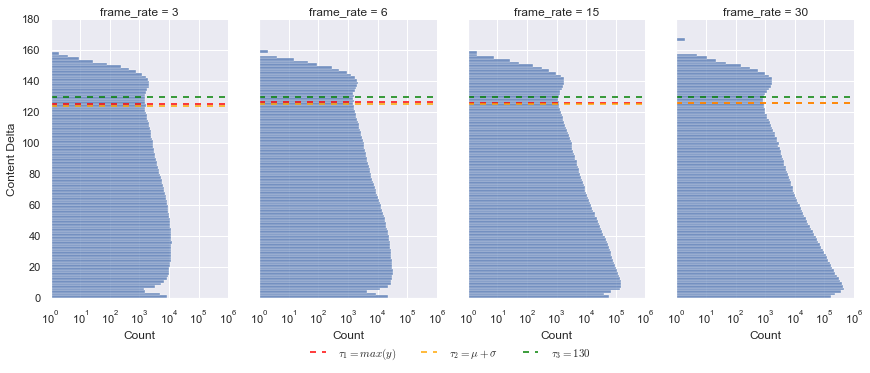

In [12]:
g = sns.FacetGrid(df3,
                  col='frame_rate',
                  height=5,
                  aspect=1/1.618,
                  sharey=True)
g.map_dataframe(my_graph(sns.histplot), y='content_delta', log_scale=(True, False), bins=100)
g.set(ylabel='Content Delta')
g.add_legend(loc='lower center', ncol=3, bbox_to_anchor=(0.4, -0.05))

In [13]:
file_names = ['0yTEcgQNoQo', 'b85zz8XkVO4', 'FD7ASrSrQk4', 'gQY-5f_w6oU']
df3_ = df3[df3['video_id'].isin(file_names)]

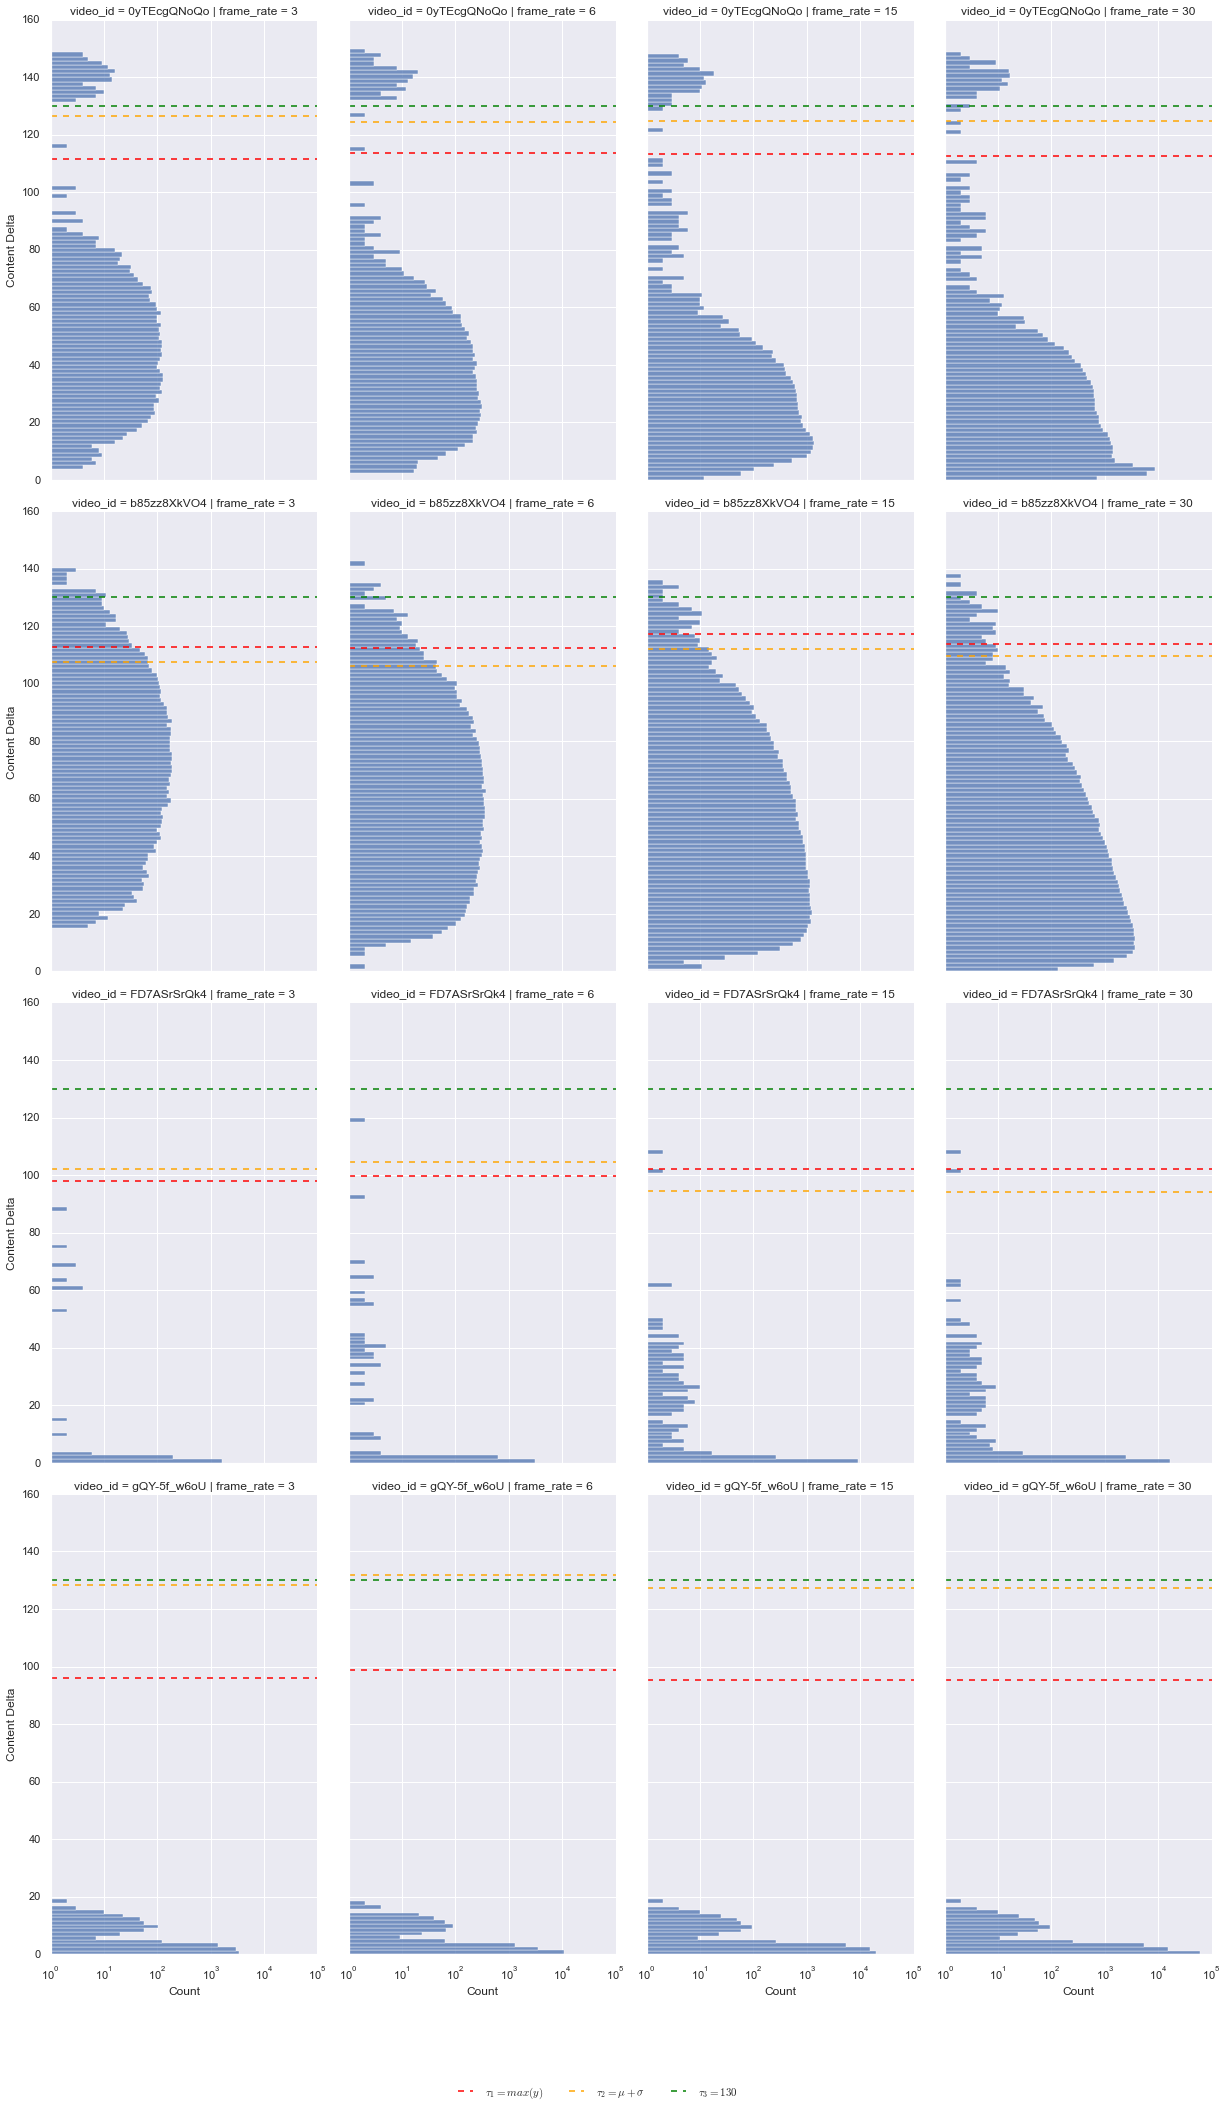

In [14]:
g = sns.FacetGrid(df3_,
                  row='video_id',
                  col='frame_rate',
                  height=7,
                  aspect=1/1.618,
                  sharey=True)
g.map_dataframe(my_graph(sns.histplot), y='content_delta', log_scale=(True, False), bins=100)
g.set(ylabel='Content Delta')
g.add_legend(loc='lower center', ncol=3, bbox_to_anchor=(0.4, -0.05))

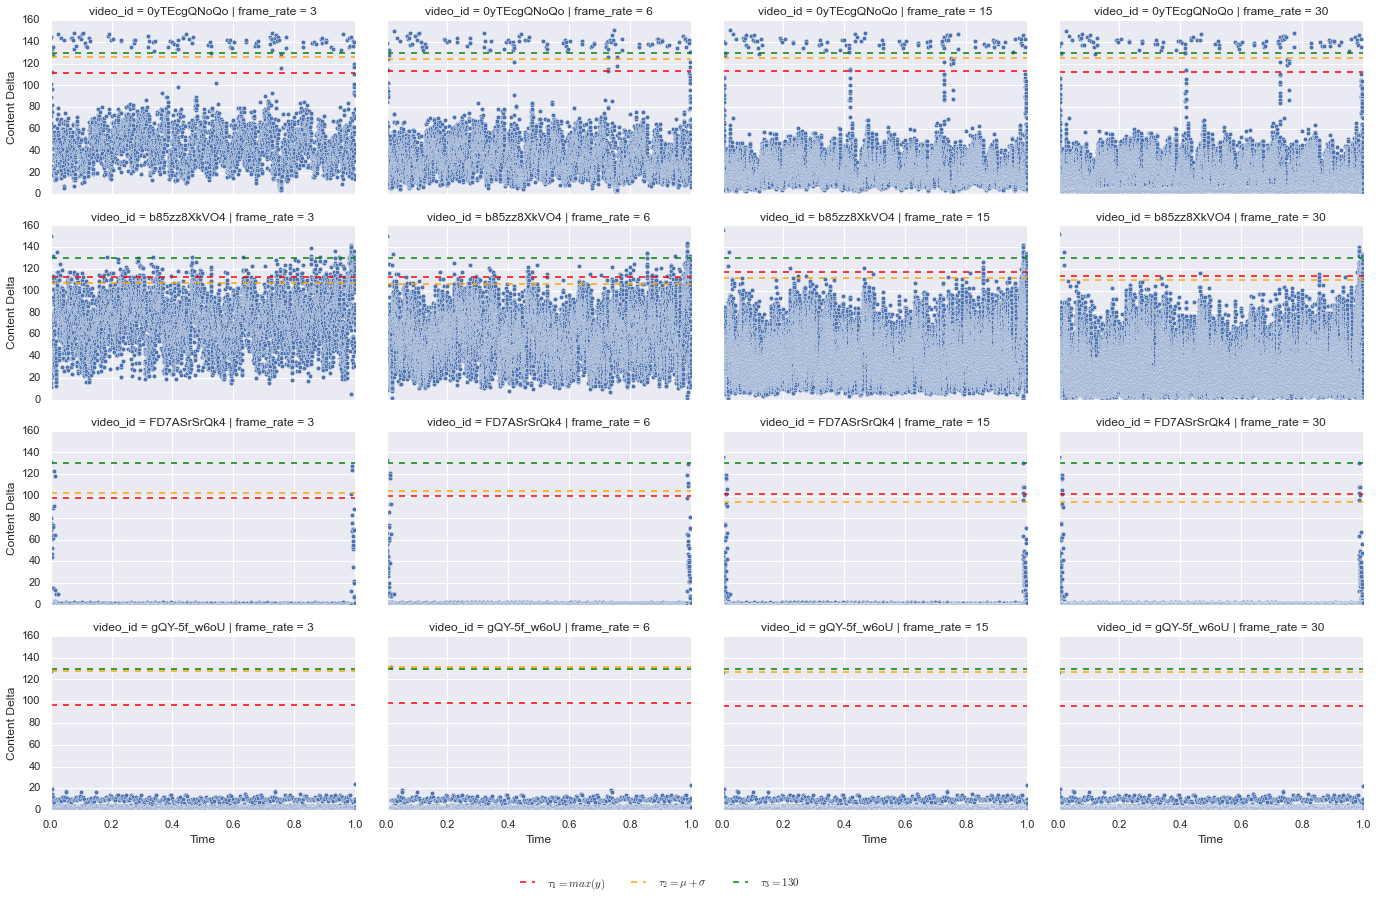

In [15]:
g = sns.FacetGrid(df3_,
                  row='video_id',
                  col='frame_rate',
                  height=3,
                  aspect=1.618,
                  sharey=True)
g.map_dataframe(my_graph(sns.scatterplot), x='time', y='content_delta')
g.set(xlabel='Time', ylabel='Content Delta', xlim=(0,1), ylim=(0,160))
g.add_legend(loc='lower center', ncol=3, bbox_to_anchor=(0.4, -0.05))